<a href="https://colab.research.google.com/github/CJP123/hut8/blob/master/_notebooks/2020-08-27-Captcha_Fastai_DataBlock_and_CTC_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR models for reading Captcha images using Fastai
> "Investigate and use CNN / RNN models and CTC Loss in pytorch / fastai"

- toc:false- branch: master- badges: true- comments: false
- author: Clive Pinfold
- categories: [custom loss, jupyter, fastai]

After seeing a few examples on [Connectionist Temporal Classification](https://en.wikipedia.org/wiki/Connectionist_temporal_classification) [CTC] loss it seemed like a chance to try out some OCR, use some custom fastai features and also get a better understanding of how CTC loss works. In reality it was a frustrating trip mainly due to the CTC loss function as it initally seemed to predict only blanks or love randomly stopping learning and produce garbage.

In the end however, once put into a fastai scaffold it highlighted the ease it is to experiment and leverage different model architectures and optimisers. I could replicate the approach taken by others and then with a few lines of code I could put in a resnet backbone and train a separate model without the RNN.

This example builds on a couple of great tutorials that demonstrate simple OCR models on a [Captcha](http://www.captcha.net/) dataset. One in Keras by [Aakash Kumar Nain](https://keras.io/examples/vision/captcha_ocr/) and a very helpful conversion to pytorch by [
Abhishek Thakur](https://www.youtube.com/watch?v=IcLEJB2pY2Y). 

In [62]:
#hide
!pip install -U fastai --quiet

Lets download and look at one of the images from the dataset.

In [63]:
from fastai.vision.all import *
from itertools import groupby

In [8]:
#collapse-hide
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    137      0  0:00:01  0:00:01 --:--:--   137
100 8863k  100 8863k    0     0  5153k      0  0:00:01  0:00:01 --:--:-- 26.1M
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


gnc3n.png


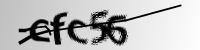

In [64]:
#hide
path = Path('captcha_images_v2') 
fns = get_image_files(path) 
print(fns[0].name)
Image.open(fns[14])

# CTC Loss 

In our images we provide the temporal aspect to the CTC loss by putting the image through some convolutions to provide richer features and permute (re-arrange) the order of the output of the CNN tensor to set the width as 'time' axis in effect sliding a window across the image. This is passed into an RNN before a final linear layer to output the number of categories of the image (the vocab). 

In this dataset all the images are 5 characters long but as detailled in the linked paper [CTC Loss](
https://distill.pub/2017/ctc/) this is not essential and CTC loss can manage variable length targets. Included images from this paper.

The CTC model produces a stream of 75 (in our models) temporal predictions. These predictions are blanks [.] and at times multiple consecutive characters. The following function condenses the stream into a coherent prediction. 

In [65]:
def strip_duplicates(str):
  return ('').join([x for x, y in groupby(str) if sum(1 for i in y) >0 if x != '.'])
# this is perhaps one of the best list comprhensions I have had the pleasure to meet 

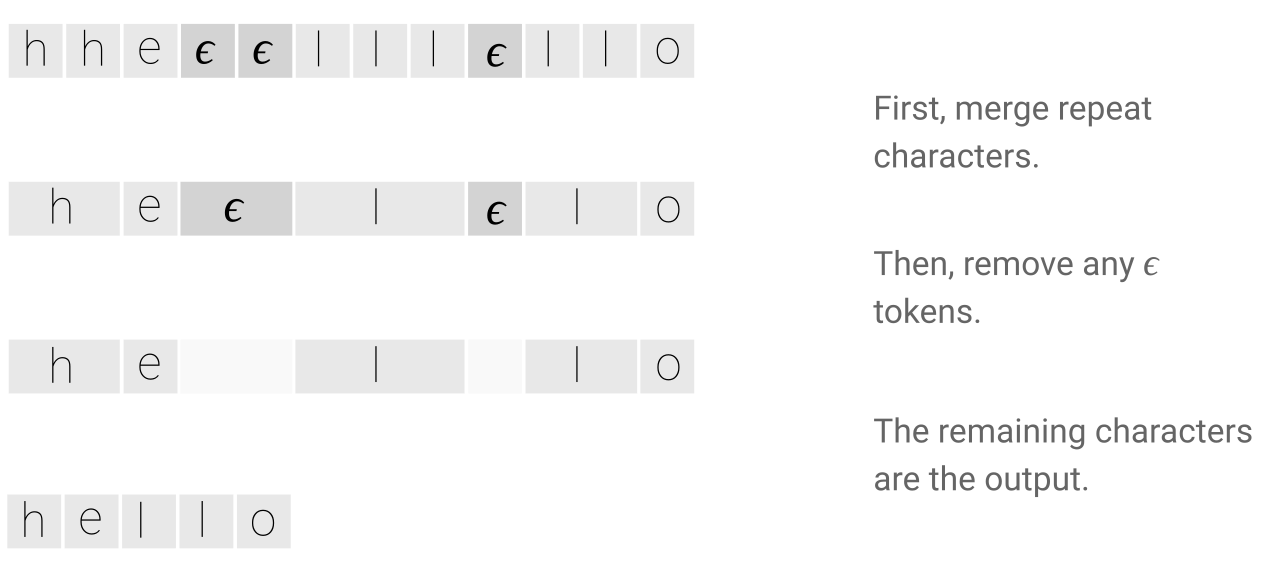

# Fastai Datablock
This problem requires an ordered list of target categories reflecting the characters. This is close to an existing MultiCategory datablock but I was keen to see how easy it was to generate one that could be used for this problem - the CaptchaBlock

In [66]:
class TensorCaptcha(TensorCategory): pass #Create a Tensor 

def CaptchaBlock(vocab=None):
    "`TransformBlock` for Captcha categorical targets"
    tfm = CaptchaCategorize(vocab=vocab)
    return TransformBlock(type_tfms=tfm)

class CaptchaCategorize(Categorize):
    "Transform of encoded Captcha-category that decodes with `vocab`"
    def __init__(self, vocab=None, sort=True, add_na=False):
        store_attr(self, self.store_attrs+',sort')
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
    
    def encodes(self, o): 
      return TensorCaptcha(torch.stack([tensor(self.vocab.o2i[x]) for x in o])) #generates a new tensor encoding the labels 

    def decodes(self, o): 
      return CaptchaCategory(('').join([Category(self.vocab[x]) for x in o])) #decodes the TensorCaptcha and returns a clean string

class CaptchaCategory(L):
    def show(self, ctx=None, sep=';', color='black', **kwargs):
        return show_title(sep.join(self.map(str)), ctx=ctx, color=color, **kwargs)


I am not certain that this code utilises all the fastai functionality but it is sufficient for the purposes of this experiment

In [67]:
def stem_label(o): return o.stem

In [68]:
# Set up the required vocab from the filenames titles. 
# '.' has been added to the front of the vocab to represent the "blank" or null character 
vocab = L('.')+L(set([x for x in ('').join([x.stem for x in fns])]))
vocab

(#20) ['.','f','n','4','w','y','2','3','6','x'...]

In [69]:
captcha = DataBlock(blocks =(ImageBlock(cls=PILImageBW), (CaptchaBlock(vocab=vocab))),
                 get_items=get_image_files, 
                 get_y = stem_label,
                 splitter=RandomSplitter(valid_pct=.05, seed=42),      
                 item_tfms = Resize((75,300))
                )
dls = captcha.dataloaders(path, bs=8)

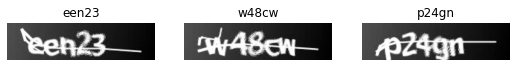

In [70]:
dls.show_batch(max_n=3)

Need to define the custome loss function for the learners. [CTC Loss in Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html)

In [71]:
def ctc_loss(inputs, targets):
  inputs = inputs.permute(1,0,2)   # re-order to the expected input for the CTC loss            
  log_probs = F.log_softmax(inputs, 2)
  input_lengths = torch.full(size=(inputs.size(1),), fill_value=inputs.size(0), dtype=torch.int32) # should be bs x rnn output
  target_lengths = torch.full(size=(inputs.size(1),), fill_value=tensor(5), dtype=torch.int32)
  loss = nn.CTCLoss(blank=0)(
          log_probs, targets, input_lengths, target_lengths
          )
  return loss

In [72]:
# print out some decoded predictions
def show_output():
  x,y=dls.valid.one_batch() #get a batch
  preds = learn.model(x) #get model predictions
  preds = torch.argmax(torch.softmax(preds, 2), 2)  
  decoded = [('').join(dls.vocab[x]) for x in preds]
  cleaned = [strip_duplicates(x) for x in decoded]
  results = zip(decoded,cleaned,[('').join(dls.vocab[x]) for x in y.detach().cpu().numpy()])
  print('Actual  | ',' '*31,'Prediction',' '*32,'| Cleaned ' )
  for res in results:
    print(res[2],'  | ',f'{res[0]} | ','.....' if len(res[1]) == 0 else res[1])

# Base Model
My first model attempted to largely duplicates the approach and code used by [Abhishek](https://github.com/abhishekkrthakur/captcha-recognition-pytorch.git)

In [73]:
class CaptchaModel(nn.Module):
  def __init__(self, num_chars=20):
    super(CaptchaModel, self).__init__()
    self.conv_1 = nn.Conv2d(1, 128, kernel_size=(3, 6))
    self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3, 6))
    self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))
    self.linear_1 = nn.Linear(1088, 64)
    self.drop_1 = nn.Dropout(0.15)
    self.gru_1 = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.15,batch_first=True)
    self.output = nn.Linear(64, num_chars)

  def forward(self, x, targets=None):
    x = F.relu(self.conv_1(x))          
    x = self.pool_1(x)
    x = F.relu(self.conv_2(x))          
    x = self.pool_2(x)                  
    x = x.permute(0, 3, 1, 2)           # change the width channel to 'time' channel order for input to the RNN
    x = x.view(x.size(0), x.size(1), -1)     
    x = F.relu(self.linear_1(x))         
    x = self.drop_1(x)                   
    x, _ = self.gru_1(x)                 
    x = self.output(x)                   
    return x

In this model the CTC loss was slow to reduce and I found the ranger optimiser provided the most consistant results.

In [74]:
learn = Learner(dls, CaptchaModel(20), opt_func=ranger, loss_func=ctc_loss)

In [75]:
#collapse-hide
learn.fit_flat_cos(50)

epoch,train_loss,valid_loss,time
0,6.609824,3.323853,00:04
1,3.532869,3.267331,00:04
2,3.290485,3.272826,00:04
3,3.270662,3.268196,00:04
4,3.270051,3.273657,00:04
5,3.269391,3.262935,00:04
6,3.267435,3.266809,00:04
7,3.271755,3.266099,00:04
8,3.269518,3.271400,00:04
9,3.267635,3.266140,00:04


With this model it is possible to produce reasonable results after 30 epochs.

In [76]:
show_output()

Actual  |                                  Prediction                                  | Cleaned 
mfb3x   |  ............m..........ff....bb........3.........xx.................... |  mfb3x
2npg6   |  ............22.....n.....ppp..........gg...66.......................... |  2npg6
d7c5x   |  ...............dd....77.....ccc....55........xx........................ |  d7c5x
77n6g   |  .............77.....77....n.......66.........gg........................ |  77n6g
6gnm3   |  ............6.........ggg...n......m.......333......................... |  6gnm3
gwnm6   |  ..............ggg.......ww....n......m............66................... |  gwnm6
7gp47   |  .............77.......ggg..pp.........44......77....................... |  7gp47
yw667   |  .............yyy...........ww....66.......66.......77.................. |  yw667


# Using a Custom Fastai CNN Head

Fastai makes it so easy to insert part of a CNN architechture into any model so lets simplyfy the model layers. No need to modify the dataset or loss functions.

In [77]:
class XResnetHeadCaptchaModel(nn.Module):
  def __init__(self, num_chars=20):
    super(XResnetHeadCaptchaModel, self).__init__()
    self.body = create_body(xresnet18, n_in=1, cut=4) #one line of code for 3 convolutions and a max pool layer
    self.linear_1 = nn.Linear(1216, 64)
    self.gru_1 = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.15,batch_first=True)
    self.output = nn.Linear(64, num_chars)

  def forward(self, x, targets=None):
    x = self.body(x)          
    x = x.permute(0, 3, 1, 2)           # change the width channel to 'time' channel order for input to the RNN
    x = x.view(x.size(0), x.size(1), -1)     
    x = F.relu(self.linear_1(x))         
    x, _ = self.gru_1(x)                 
    x = self.output(x)                   
    return x

In [78]:
learn = Learner(dls, XResnetHeadCaptchaModel(20), opt_func=ranger, loss_func=ctc_loss)

In [79]:
#collapse-hide
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,time
0,36.014141,33.254025,00:03
1,23.298916,15.777877,00:03
2,10.088671,6.058345,00:03
3,4.672950,3.596047,00:03
4,3.458390,3.295455,00:03
5,3.290624,3.274989,00:03
6,3.270075,3.270474,00:03
7,3.269157,3.272807,00:03
8,3.267462,3.269497,00:03
9,3.259346,3.249301,00:03


In [80]:
show_output()

Actual  |                                  Prediction                                  | Cleaned 
mfb3x   |  .............m............f.....b.......33.........x....................... |  mfb3x
2npg6   |  ...............22...n.......pp.......g.......66............................ |  2npg6
d7c5x   |  .............d..........7....cc......5.........xx.......................... |  d7c5x
77n6g   |  ...............7......77...n.......66......gg.............................. |  77n6g
6gnm3   |  .............66......g........n......m.......33............................ |  6gnm3
gwnm6   |  .............g.......w.........n.......m...........66...................... |  gwnm6
7gp47   |  ...............77....g.......pp.........44......7.......................... |  7gp47
yw667   |  .............yy........w..........666......66........77.................... |  yw667


# CNN Only Model
The others models combine a CNN and RNN. The CNN is permuted and reshaped before entering the RNN so that it already should have some sense of "time" order to feed into the CTC loss even without the RNN. This model will remove the RNN from the model and see if can still learn. We will also feed the flattened output of the CNN through just one linear layer.

In [81]:
class ThreeLayerCNNCaptchaModel(nn.Module):
  def __init__(self, num_chars=20):
    super(ThreeLayerCNNCaptchaModel, self).__init__()
    self.body = create_body(xresnet18, n_in=1, cut=4)
    self.output = nn.Linear(1216, num_chars)

  def forward(self, x, targets=None):
    x = self.body(x)          
    x = x.permute(0, 3, 1, 2)           # change the width channel to 'time' channel order for input to the RNN
    x = x.view(x.size(0), x.size(1), -1)     
    x = self.output(x)                   
    return x

In [82]:
learn = Learner(dls, ThreeLayerCNNCaptchaModel(20), loss_func=ctc_loss, opt_func=ranger)

In [83]:
#collapse-hide
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,time
0,3.639349,3.348868,00:01
1,3.344151,3.329033,00:01
2,3.294963,3.317898,00:01
3,3.274048,3.278011,00:01
4,3.190333,3.232394,00:01
5,2.064031,1.264510,00:01
6,0.911614,0.692102,00:01
7,0.511333,0.383044,00:01
8,0.357558,0.466906,00:01
9,0.278443,0.274079,00:01


In [84]:
show_output()

Actual  |                                  Prediction                                  | Cleaned 
mfb3x   |  ...............f........ff....b............3........x...................... |  ffb3x
2npg6   |  ................22...........pp.......gg....6.............................. |  2pg6
d7c5x   |  ................dd.......7......cc..55..........xx......................... |  d7c5x
77n6g   |  ................7......77.........66..........g............................ |  776g
6gnm3   |  ............66.........gg.......n.....m........33.......................... |  6gnm3
gwnm6   |  ..............ggg......ww........n.......n........6........................ |  gwnn6
7gp47   |  ................77.....gg......p......44.........7......................... |  7gp47
yw667   |  .................y.......ww.......6.......66..........777.................. |  yw667


The CNN only model cannot seem to get the accuracy of the mixed CNN / RNN model but suprisingly does a pretty reasonable job. 

It should be easy to see the core strength of Fastai allows quick experimentation. It is easy to take a model and test (and abandon) different approaches. This is a toy example but the ability to simply add the head of a  XResnet18 backbone to simplify the model code and play around really helpped me to gain confidence in experimentation. 